In [31]:
from models.MNIST_Models import MNIST_FC_500_100_10
import torchvision.models as models
import torch
from torchvision.datasets import Imagenette
import torchattacks
import torchvision.transforms as transforms
import numpy as np
import os
import utils

In [32]:
net = models.resnet18(weights='DEFAULT').eval()

Orig Label tensor([6])
Actual class name ['garbage truck']
Running attack
Pre tensor([569])
Post tensor([867])


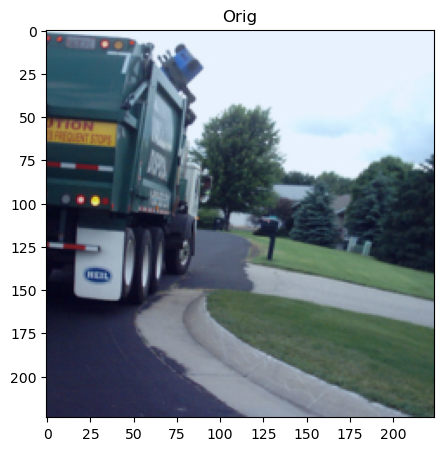

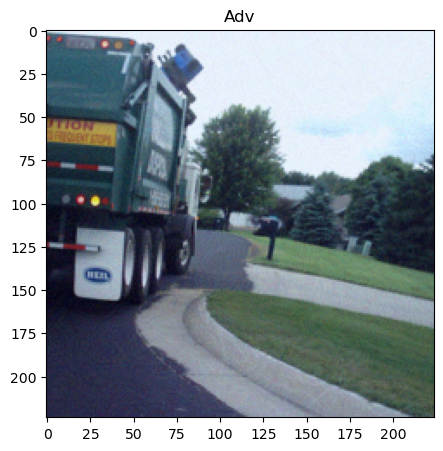

In [36]:
# Switch to evaluation mode

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the root directory and the transforms
root_dir = './data'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)])

# Set the seed for generating random numbers
torch.manual_seed(0)
np.random.seed(0)

# Create an instance of the Imagenette class
try:
    imagenette_train_data = Imagenette(root=root_dir, split='train', transform=transform, download=True)
except:
    imagenette_train_data = Imagenette(root=root_dir, split='train', transform=transform, download=False)

train_loader = data_loader = torch.utils.data.DataLoader(imagenette_train_data, batch_size=1, shuffle=True)
imgs, label = next(iter(train_loader))
print('Orig Label', label)
print('Actual class name', [imagenette_train_data.classes[i][0] for i in label])

# Create an instance of a DeepFool attack
attack = torchattacks.PGD(net, eps=8/255, alpha=2/225, steps=1)
attack.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
print('Running attack')
adv_images = attack(imgs, torch.tensor([569]))

# Get the predictions for the adversarial images
labels = open(os.path.join('deepfool_research/synset_words.txt'), 'r').read().split('\n')

pre = utils.get_pred(net, imgs, device='cpu')
post = utils.get_pred(net, adv_images, device='cpu')
print('Pre', pre)
print('Post', post)
utils.imshow(imgs[0], 'Orig')
utils.imshow(adv_images[0], 'Adv')